# Injecting signals into TESS light curves.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 10)

import os
import glob

from astropy.io import fits
import eleanor

import tess_cpm
import tess_rotation as tr
from tess_rotation import *

import warnings
warnings.filterwarnings('ignore')

import requests
from astroquery.mast import Tesscut

from tess_stars2px import tess_stars2px_function_entry

import starspot as ss
import astropy.stats as aps

In [2]:
south = pd.read_csv("../../data/cvz_south_16th.csv")

Load the eleanor FFI cut out and plot the aperture.

In [3]:
ticid = "349061281"  # Flat CPM example.
star = eleanor.Source(tic=ticid, sector=1, tc=True)

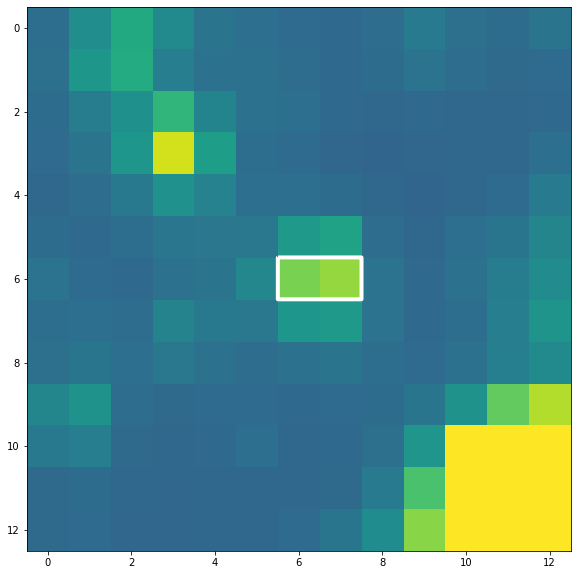

In [4]:
data = eleanor.TargetData(star)
q = data.quality == 0

vis = eleanor.Visualize(data)
vis.aperture_contour(vmin=0, vmax=300);

Load the TESScut cut out for this star.

In [5]:
path_to_tesscut = "/Users/rangus/projects/TESS-rotation/data/TESScut/astrocut_107.471456786207_-61.5366731480293_68x68px"
fits_image_filename = "{}/tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut.fits".format(path_to_tesscut)

In [6]:
hdul = fits.open(fits_image_filename)
# hdul.info()
postcard = hdul[1].data
cols = hdul[1].columns
hdr = hdul[0].header

Plot the same 13 x 13 grid as the Eleanor postcard.

(1282, 68, 68)


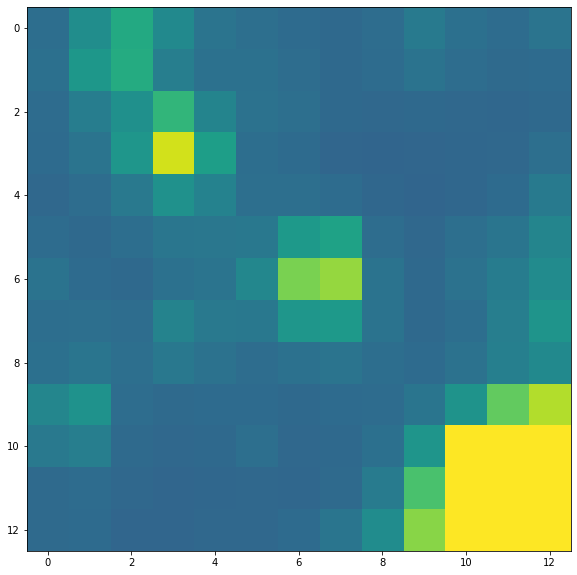

In [7]:
time = postcard["TIME"]*1.
flux = postcard["FLUX"]*1.
print(np.shape(flux))

plt.imshow(flux[0, 27:40, 28:41], vmin=0, vmax=300)

Print the Eleanor centroid and the TESSpoint data.

In [8]:
print(star.sector, star.camera, star.chip, star.position_on_chip, star.locate_on_tess(), star.position_on_chip)

1 4 3 [1625  612] None [1639.28399742  627.65144243]


In [9]:
from tess_stars2px import tess_stars2px_function_entry

m = south.ID.values == int(ticid)
ra = south.ra.values[m]
dec = south.dec.values[m]
ticid = south.ID.values[m]
print("Tmag = ", south.Tmag.values[m])

outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, outColPix, outRowPix, scinfo = \
    tess_stars2px_function_entry(int(ticid), ra, dec)
print(outColPix[0], outRowPix[0], outCcd[0], outCam[0], outSec[0])

Tmag =  [15.00290012]
1639.2839974213725 627.6514424285949 3 4 1


Get the PRF at this pixel location.

In [10]:
path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"
prf = getPrfAtColRowFits(outColPix[0], outRowPix[0], outCcd[0], outCam[0], outSec[0], path)  # col, row, ccd, camera, sector
print(np.shape(prf))

(117, 117)


In [11]:
offset_y = 0.  # this should really be an array that tracks the row and column motions 
offset_x = 0.  # of the centroid of a star. You can calculate those yourself by taking a bright isolated star
                   # and calculating the center of mass at each cadence and dropping that in, or running eleanor and
                  # taking data.x_com (I think) would get you the same thing and you can drop in those offsets.

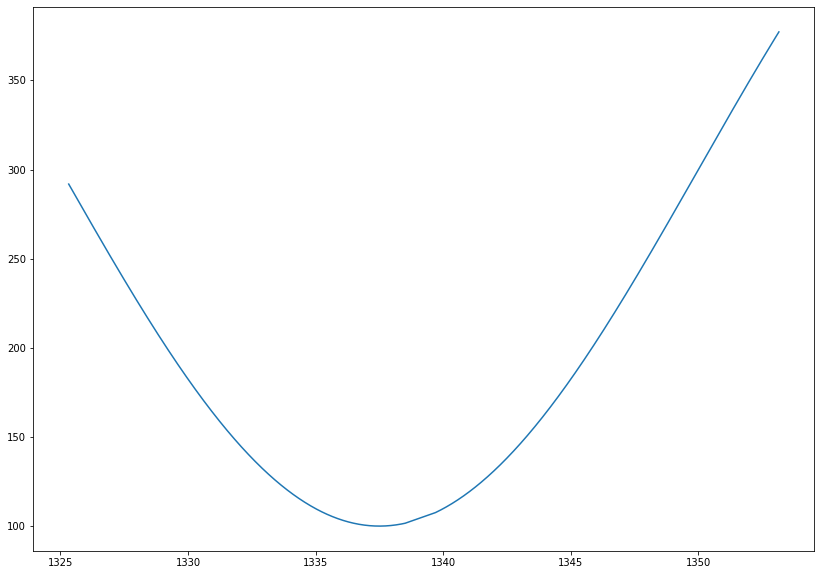

In [17]:
signal = 300 + 200*np.sin(time*2*np.pi/50)  # simple sine wave, you can change it to something more realistic
plt.plot(time, signal)

In [18]:
# injected_flux = flux[:, 27:40, 28:41] + signal[:, None, None] * move_prf(prf, offset_x, offset_y)[None, :, :]
injected_flux = flux + signal[:, None, None] * move_prf(prf, offset_x, offset_y, npix=68)[None, :, :]

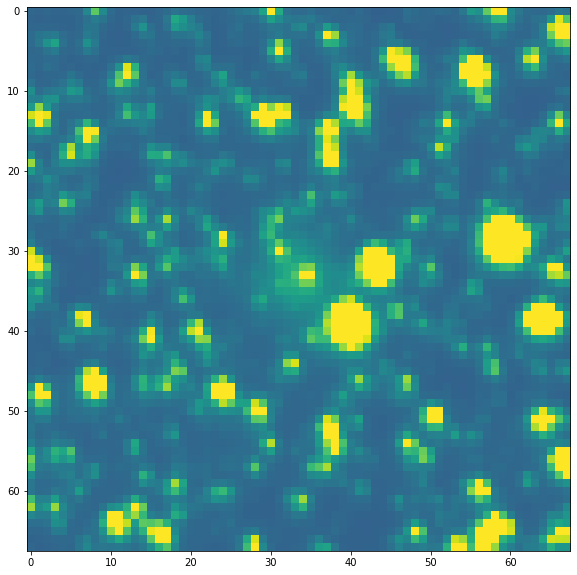

In [19]:
plt.imshow(injected_flux[0, :, :], vmin=0, vmax=300)

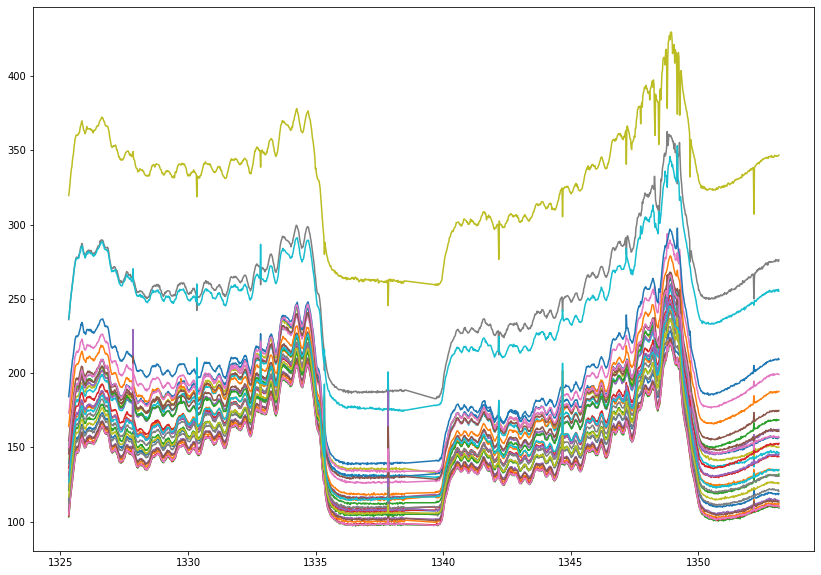

In [20]:
for i in range(15, 45):
    plt.plot(time, injected_flux[:, i, 34])

In [21]:
hdul[1].data["FLUX"] = injected_flux

if not os.path.exists("tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut_injected.fits"):
    hdul.writeto("tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut_injected.fits")
    hdul.close()
else:
    os.remove("tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut_injected.fits")
    hdul.writeto("tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut_injected.fits")
    hdul.close()

# Try to recover signal with CPM.

Calculate the aperture in the format needed for CPM.

In [2]:
def get_CPM_aperture(aperture, npix=13, xstart=27, ystart=28):
    x = np.arange(npix)
    row_index, column_index = np.meshgrid(x, x, indexing="ij")
    aperture_mask = aperture == 1
    column_inds = column_index[aperture_mask]
    row_inds = row_index[aperture_mask]
    xpixels = tuple(xstart + row_inds)
    ypixels = tuple(ystart + column_inds)
    return xpixels, ypixels

xpixels, ypixels = get_CPM_aperture(data.aperture)

NameError: name 'data' is not defined

Get CPM light curve for original FFI

/Users/rangus/projects/TESS-rotation/data/TESScut/astrocut_107.471456786207_-61.5366731480293_68x68px/tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut.fits
Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array


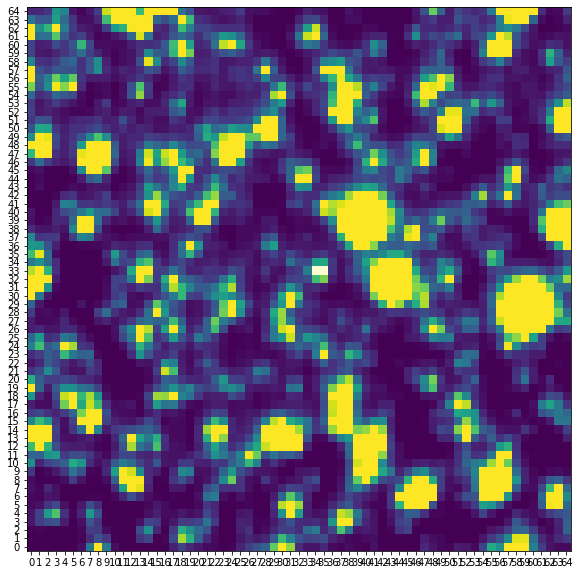

((34, 35), (33, 33))

In [23]:
sector = 1
fits_files = glob.glob("{0}/tess-s00{1}-*_astrocut.fits".format(path_to_tesscut, str(sector).zfill(2))) 
print(fits_files[0])
tr.select_aperture(sector, ypixels, xpixels, fits_files[0], plot=True)

Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves


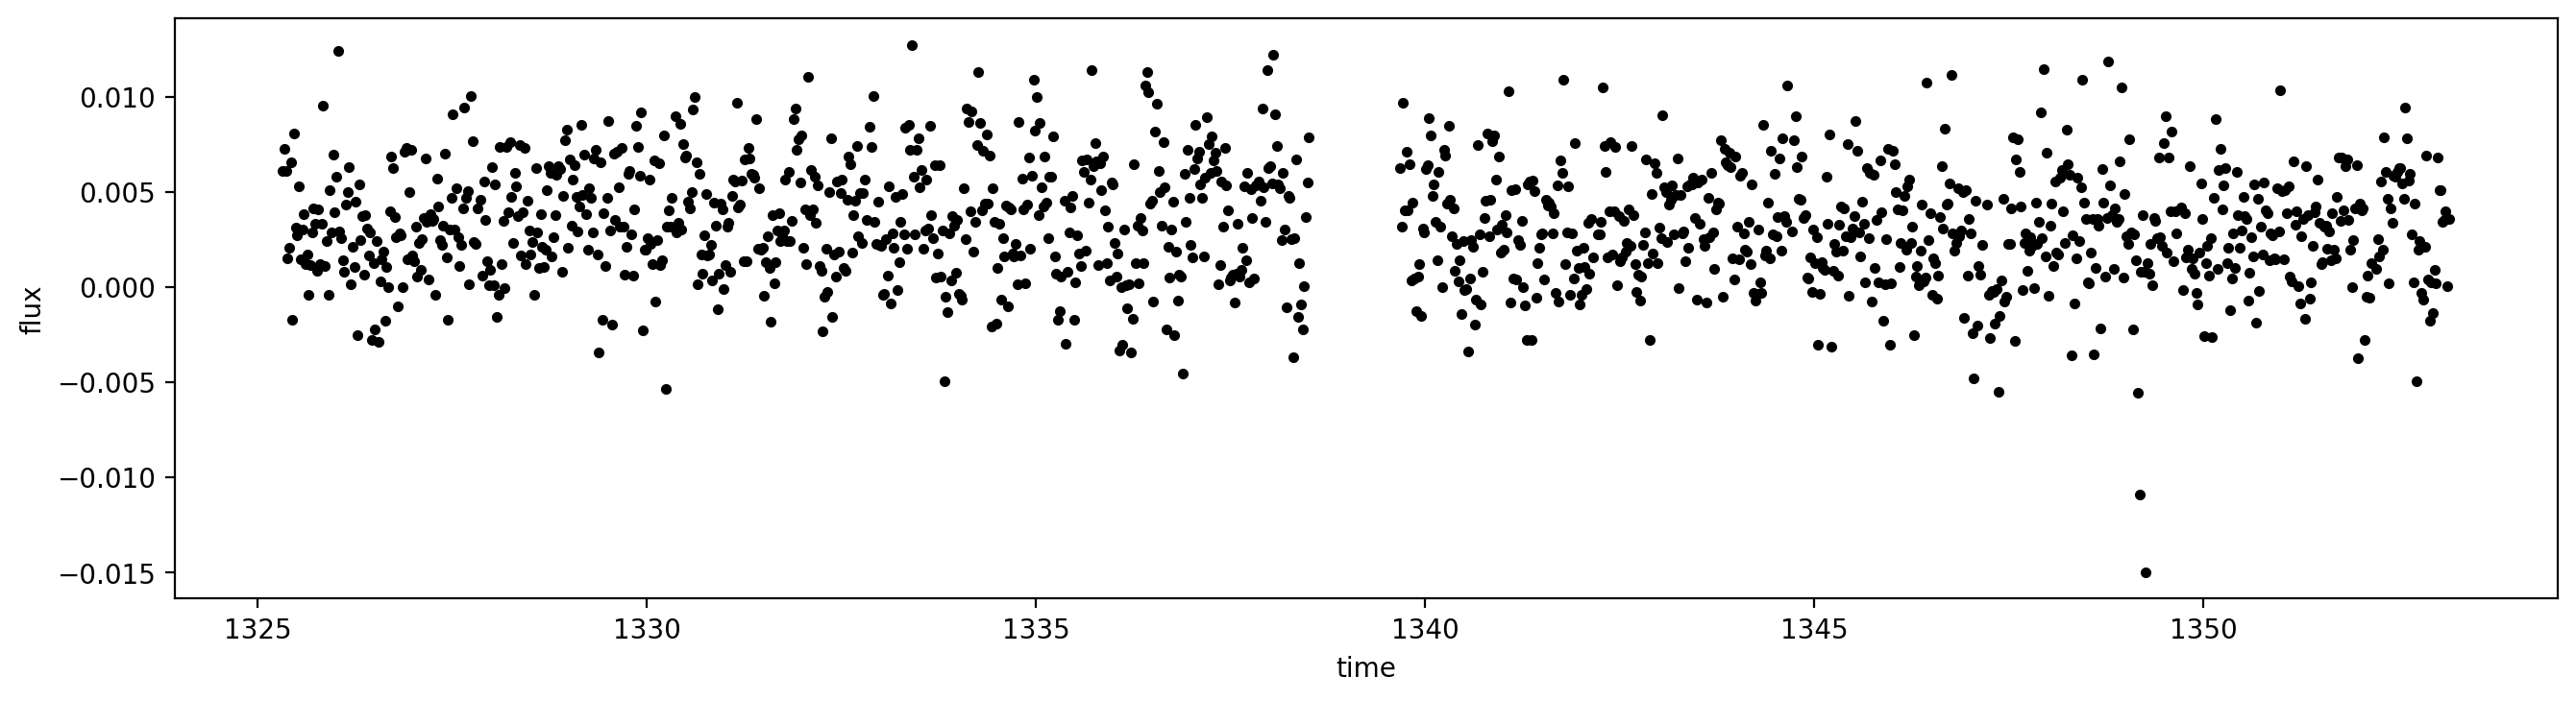

In [24]:
_x, _y = tr.make_lc_single_sector(sector, ypixels, xpixels, fits_files[0], plot=True, save_to_file=False)

Get CPM light curve for injected FFI.

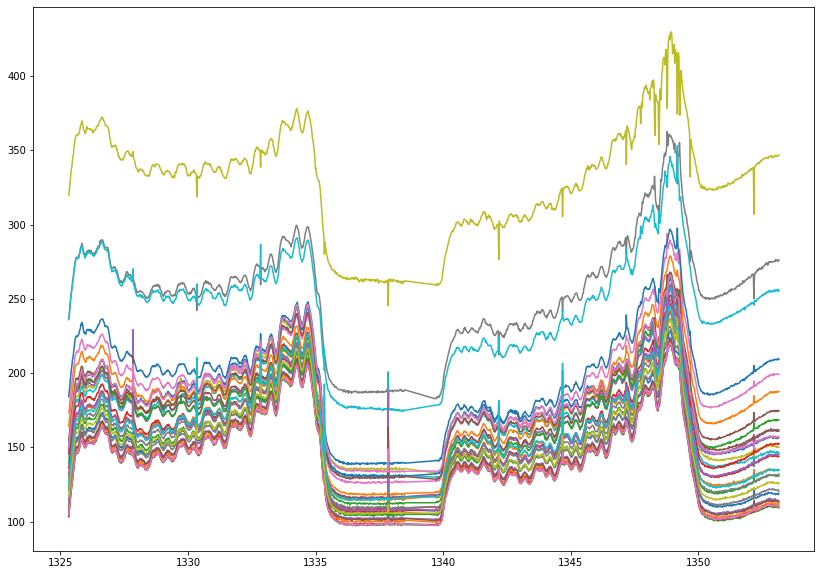

In [25]:
with fits.open("tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut_injected.fits") as hdu2:
    postcard2 = hdu2[1].data
    
for i in range(15, 45):
    plt.plot(time, postcard2["FLUX"][:, i, 34])

Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array


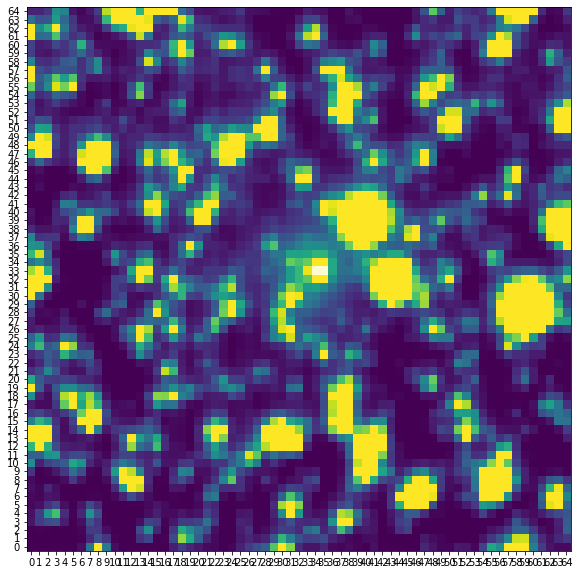

Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves


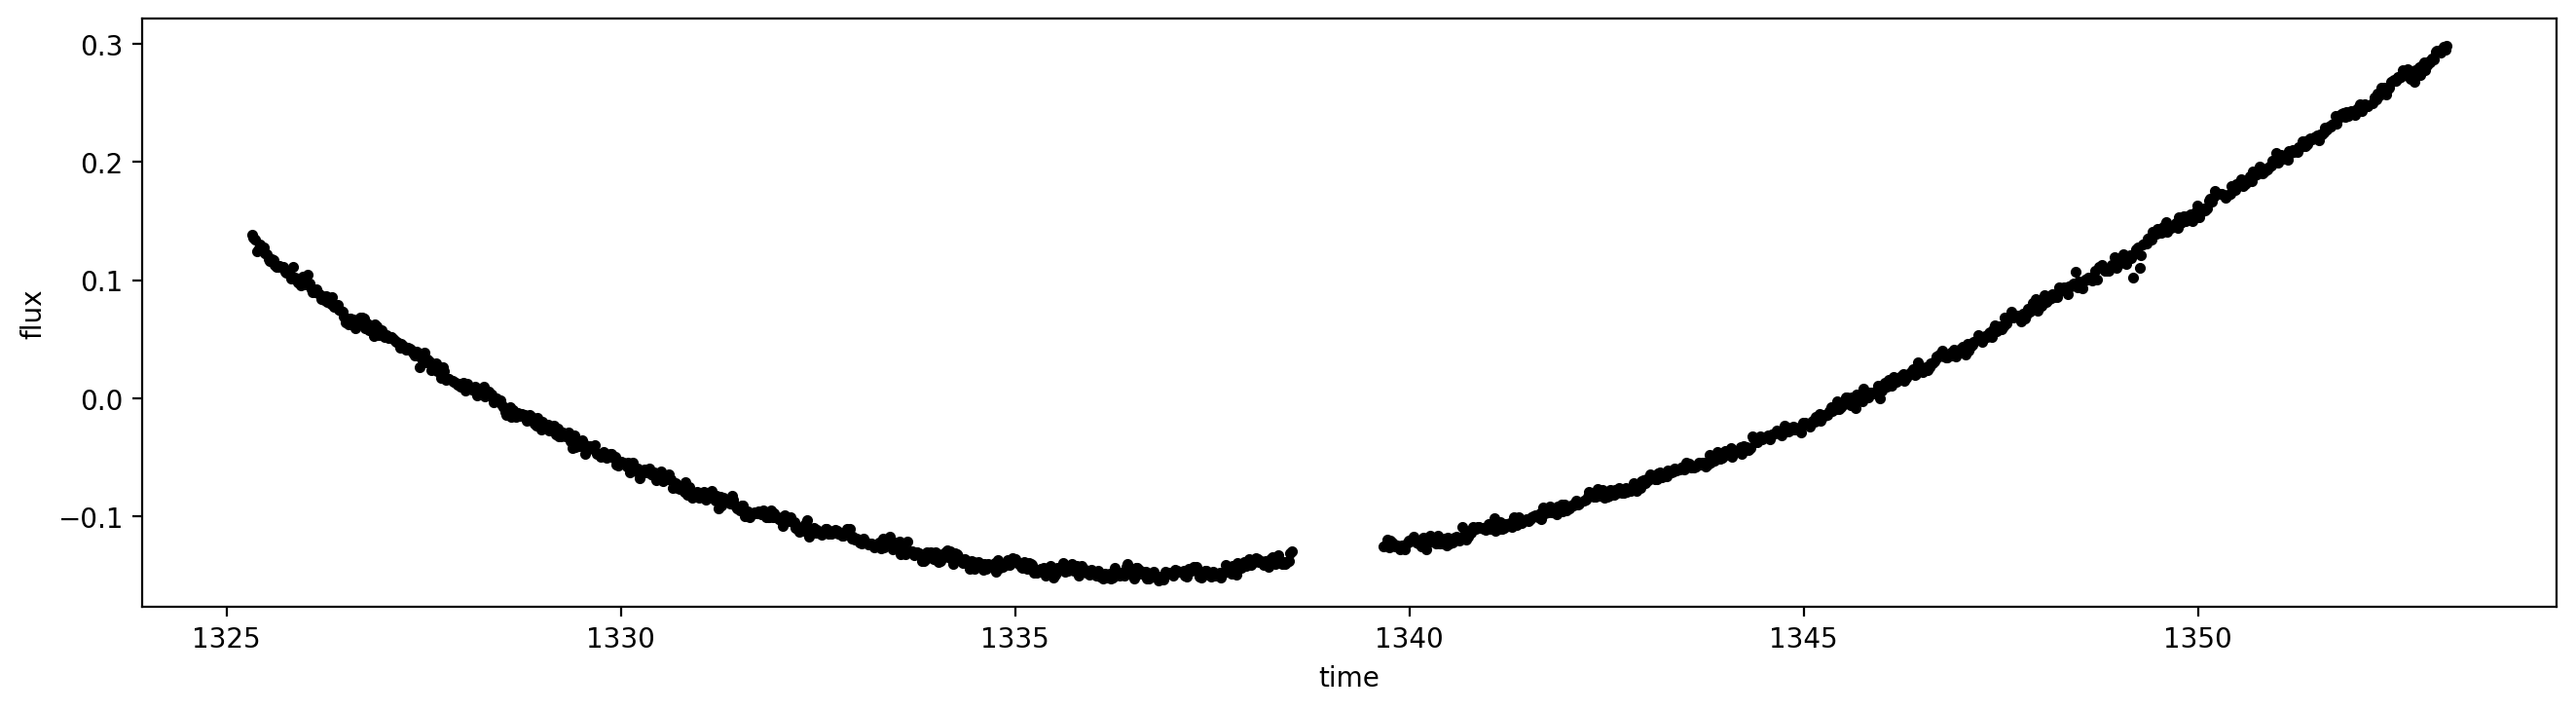

In [27]:
tr.select_aperture(sector, ypixels, xpixels, "tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut_injected.fits", plot=True)
x, y = tr.make_lc_single_sector(sector, ypixels, xpixels, "tess-s0001-4-3_107.471457_-61.536673_68x68_astrocut_injected.fits",
                                plot=True, save_to_file=False)

# Make a pipeline that injects an arbitrary signal automatically

Injection functions.

In [62]:
def get_sectors(ticid, any_observed_sector):
    star = eleanor.Source(tic=ticid, sector=any_observed_sector, tc=True)
    outID, outEclipLong, outEclipLat, outSec, outCam, outCcd, outColPix, outRowPix, scinfo = \
        tess_stars2px_function_entry(int(ticid), star.coords[0], star.coords[1])
    sectors = outSec[outSec < 14]
    return sectors, star


def get_fits_filenames(tesscut_path, sector, camera, ccd, ra, dec, xpix=68, ypix=68):
    path_to_tesscut = "{0}/astrocut_{1:12}_{2:13}_{3}x{4}px".format(tesscut_path, ra, dec, xpix, ypix)
    
    fits_image_filename = "{0}/tess-s{1}-{2}-{3}_{4:.6f}_{5:.6f}_{6}x{7}_astrocut.fits".format(
        path_to_tesscut, str(int(sector)).zfill(4), camera, ccd, ra, dec, xpix, ypix)
    
    injection_filename = "tess-s{0}-{1}-{2}_{3:.6f}_{4:.6f}_{5}x{6}_astrocut_injected.fits".format(
        str(int(sector)).zfill(4), camera, ccd, ra, dec, xpix, ypix)
    return fits_image_filename, injection_filename


def inject_signal(ticid, period, amplitude, baseline, tesscut_path, any_observed_sector=1, xpix=68, ypix=68):

    sectors, star = get_sectors(ticid, any_observed_sector)
    
    # Eleanor object
    print("Finding Eleanor object...")
    for sector in sectors:
        print("sector", sector)
                
        print(ticid, sector)
        star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
        sec, camera, ccd, colrowpix = star.sector, star.camera, star.chip, star.position_on_chip
        
        fits_image_filename, injection_filename = get_fits_filenames(tesscut_path, sec, camera, ccd, star.coords[0], star.coords[1])
        
        inject_one_sector(ticid, sector, period, amplitude, baseline, sec, camera, ccd, colrowpix, fits_image_filename, injection_filename)

    
def inject_one_sector(ticid, sector, period, amplitude, baseline, sec, camera, ccd, colrowpix, fits_image_filename, injection_filename,
                      offset_x, offset_y):
    
    # Load the TESScut FFI data
    print("Loading TESScut FFI...")
    hdul = fits.open(fits_image_filename)
    postcard = hdul[1].data
    time = postcard["TIME"]*1.
    flux = postcard["FLUX"]*1.

    # Get the PRF
    print("Fetching PRF...")
    path = "https://archive.stsci.edu/missions/tess/models/prf_fitsfiles/"
    prf = getPrfAtColRowFits(colrowpix[0], colrowpix[1], ccd, camera, sec, path)  # col, row, ccd, camera, sector
    
    # Simulate the signal
    signal = baseline + amplitude*np.sin(time*2*np.pi/period)  # simple sine wave, you can change it to something more realistic
    
    # Inject the signal and save the new file.
    print("Injecting signal and saving...")
    injected_flux = flux + signal[:, None, None] * move_prf(prf, offset_x, offset_y, npix=68)[None, :, :]
    hdul[1].data["FLUX"] = injected_flux
    if os.path.exists(injection_filename):
        os.remove(injection_filename)
    hdul.writeto(injection_filename)
    hdul.close()

CPM functions.

In [57]:
def CPM_one_sector(ticid, tesscut_path, sector, camera, ccd, ra, dec):
    orig, fits_file = get_fits_filenames(tesscut_path, sector, camera, ccd, ra, dec, xpix=68, ypix=68)

    # Get the Eleanor aperture
    star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
    data = eleanor.TargetData(star)
    xpixels, ypixels = get_CPM_aperture(data.aperture)

    # Create CPM light curve
    tr.select_aperture(sector, ypixels, xpixels, fits_file, plot=False)
    x, y = tr.make_lc_single_sector(sector, ypixels, xpixels, fits_file, plot=False, save_to_file=False)
    return x, y
    

def CPM_recover(ticid, tesscut_path, any_observed_sector=1):
    
    sectors, star = get_sectors(ticid, any_observed_sector)
    
    xs, ys = [], []
    for sector in sectors:
        print("sector", sector)
        star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
        print(star.camera, star.chip)
        x, y = CPM_one_sector(ticid, tesscut_path, star.sector, star.camera, star.chip, star.coords[0], star.coords[1])
        xs.append(x)
        ys.append(y)

    return xs, ys

def stitch_light_curve(time, flux):
    
    time = np.array([i for j in time for i in j])
    flux = np.array([i for j in flux for i in j])
    
    sector_times = pd.read_csv("sector_times.csv")
    sectors, star = get_sectors(ticid, 1)
    gap_times = []
    for sector in sectors:
        st = sector_times.event.values == "start"
        m = sector == sector_times.sector.values[st]
        gap_times.append(float(sector_times.TJD.values[st][m]))
    gap_times.pop(0)
    
    # Estimate flux uncertainties
    m = ss.sigma_clip(flux, nsigma=6)
    t1, f1 = time[m], flux[m]

    # Then a sigma clip using a Sav-Gol filter for smoothing
    mask, smooth = ss.filter_sigma_clip(t1, f1, window_length=99)
    t2, f2 = t1[mask], f1[mask]
    f2_err = np.ones_like(t2) * 1.5 * aps.median_absolute_deviation(f2-smooth[mask])

    x, y, yerr = t2[::10], f2[::10], f2_err[::10] 

    # Calculate the best-fit offsets
    print("Fitting GP and offset model...")
    steps = np.zeros(len(gap_times))
    star = ss.StitchModel(x, np.ascontiguousarray(y, dtype=np.float64), yerr, gap_times, steps, 2.0)
    star.model_offsets()
    map_soln = star.find_optimum()
    mu_gp, var = star.evaluate_model(x)

    best_steps = []
    for i in range(len(steps)):
        best_steps.append(float(map_soln[0][f"step{i+1}"]))
    
    # Create the stitched light curve
    stitched = f2 - ss.step_model(t2, gap_times, best_steps)
    
    return t2, stitched, f2_err

Inject a signal.

In [73]:
ticid = "349061281"  # Flat CPM example.
period, amplitude, baseline = 50, 2, 300
tesscut_path = "/Users/rangus/projects/TESS-rotation/data/TESScut/"
inject_signal(ticid, period, amplitude, baseline, tesscut_path)

Finding Eleanor object...
sector 1
349061281 1
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 2
349061281 2
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 3
349061281 3
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 4
349061281 4
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 6
349061281 6
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 7
349061281 7
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 8
349061281 8
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 9
349061281 9
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 10
349061281 10
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 11
349061281 11
Loading TESScut FFI...
Fetching PRF...
Injecting signal and saving...
sector 12
349061281 12
Loading TESScut FFI...
Fetching PRF..

# Recover signal with CPM

In [74]:
ticid = "349061281"  # Flat CPM example.

In [75]:
tesscut_path = "/Users/rangus/projects/TESS-rotation/data/TESScut"
time, flux = CPM_recover(ticid, tesscut_path)

sector 1
4 3
Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
Removing 15 bad data points (out of 1282) using the TESS provided QUALITY array
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
sector 2
4 4
Removing 17 bad data points (out of 1245) using the TESS provided QUALITY array
Removing 17 bad data points (out of 1245) using the TESS provided QUALITY array
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
sector 3
4 4
Removing 13 bad data points (out of 1288) using the TESS provided QUALITY array
Removing 13 bad data points (out of 1288) using the TESS provided QUALITY array
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
Summing over 1 x 2 pixel lightcurves
sector 4
4 4
Removing 14 bad data poi

In [76]:
time_stitched, flux_stitched, flux_err_stitched = stitch_light_curve(time, flux)

Fitting GP and offset model...


optimizing logp for variables: [step11, step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
65it [00:00, 736.74it/s, logp=6.170355e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 588.1120274892502 -> 6170.354603829929


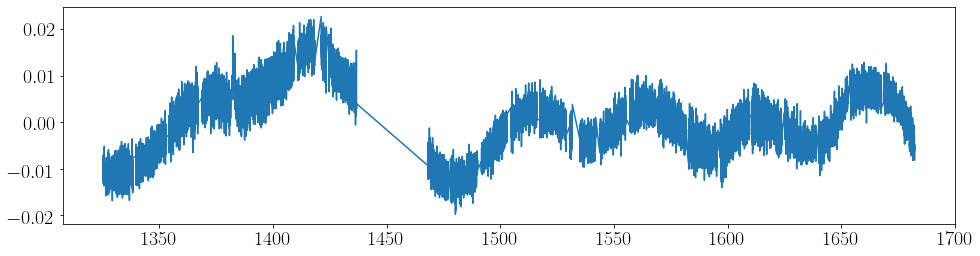

In [77]:
plt.figure(figsize=(16, 4))
p = np.polyfit(time_stitched, flux_stitched, 2)
plt.plot(time_stitched, flux_stitched - np.polyval(p, time_stitched))

In [78]:
star = ss.RotationModel(time_stitched, flux_stitched, flux_err_stitched)

In [83]:
ls_period = star.ls_rotation(max_period=100)
ls_period

50.37631483496554

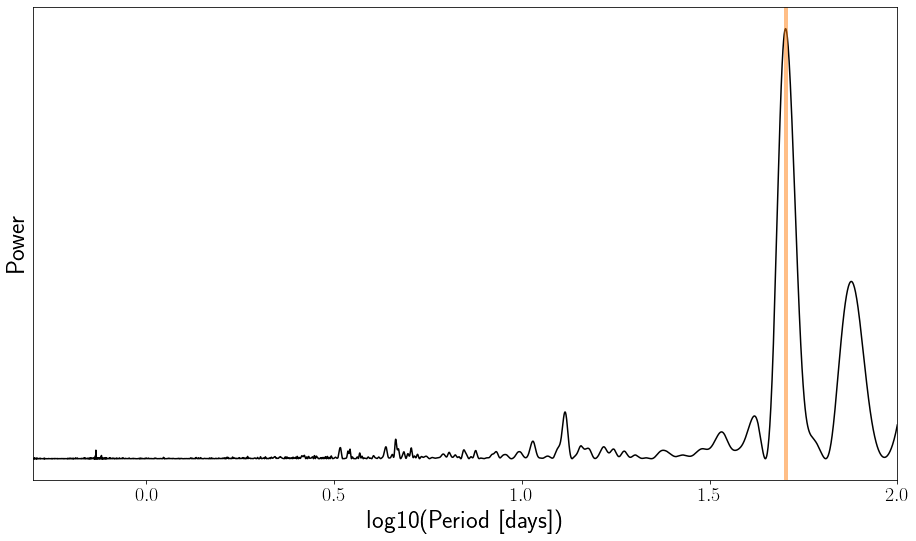

In [84]:
star.ls_plot();